# RECOMENDACIONES TURÍSTICAS EN BASE A RECONOCIENTO DE IMÁGENES 

Con la intención de fomentar el turismo en países latinoamericanos, he escogido tres países para crear y entrenar una base de datos a la cual le pasaré una imagen y como resultado, obtendré posibles paquetes turísticos de los siguientes países:

    - Ecuador
    - Perú
    - Bolivia
    
Para ello, sacaré las imágenes a trabajar de una página que ofrece paquetes turísticos, crearé un DataFrame al cual entrenaré las imágenes en base a sus vectores. 

Con las imágenes entrenadas, de la misma empresa turística, pasaré nuevas imágenes de localidades de países distintos a los 3 análizados. Al escoger una imagen de este nuevo DataFrame de pruebas, el resultado será un máximo de 15 tours que pueden coincidir con la imagen de pruebas.  

### LIBRERÍAS 

Importo todas las librerías que usaré en el proyecto dentro de las principales están:

    - Librerías para llamar a la Api para conseguir la información de la base de datos a crear. 
    - Librerías para entrenar el modelo y crear los vectores necesarios para trabajar en las imágenes a procesar y posteriomente recomendar.
    - Librerías para comparar los vectores resultantes del modelo entrenado vs los vectores de la imagen de prueba.
    

In [2]:
import requests


In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import umap

In [3]:

from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="paper", style="white")

In [4]:
from embetter.grab import ColumnGrabber
from embetter.vision import ImageLoader, TimmEncoder
from sklearn.pipeline import make_pipeline
from embetter.base import EmbetterBase

In [6]:
import sys

In [7]:
!{sys.executable} -m pip install StringIO

ERROR: Could not find a version that satisfies the requirement StringIO (from versions: none)
ERROR: No matching distribution found for StringIO


In [8]:
from PIL import Image
import io

In [9]:
from sklearn.cluster import KMeans

In [10]:
from sklearn.metrics import pairwise_distances

In [11]:
pip install ipyplot

Note: you may need to restart the kernel to use updated packages.


In [12]:
import ipyplot

In [13]:
!python -m pip install "embetter[vision]"

In [400]:
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances


### BASE DE DATOS

Una vez inspeccionada la web de donde extraeré información, paso los códigos de la localización de los 3 países de los que quiero obtener la recomendación. 

Defino las funciones necesarias para poder extraer y procesar la información de la API y con ello, crear un DataFrame listo para ser entrenado. 

In [14]:
url_code = [('504'),
        ('532'),
        ('368'),
        ('2262'),
       ('2259'),
        ('371'),
        ('2234'),
        ('2261'),
        ('148437'),
        ('2229'), 
        ('2256'),
        ('2257'),
        ('2688'),
        ('160051'),
        ('39'),
        ('148825'),
        ('359'),
        ('2859'),
        ('32157'),
        ('2146'),
        ('4674'),
        ('139396'),
        ('181551')]

headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/111.0',
    'accept-currency': 'EUR',
    'geo-ip-country': 'ES'
}

In [15]:
# defino una función para que itere con todos los códigos de la lista 'url_code'

def url_results(url_code, headers):
    url_destiny_list = []
    for code in url_code:
        location = code
        url = f'https://travelers-api.getyourguide.com/search/v2/search?p=2&searchContext=LOCATIONS&locations={location}&size=96&offset=0&sortBy=popularity'
        resp = requests.get(url, headers=headers)
        results = resp.json()
        url_destiny_list.append(results)
    return url_destiny_list
        

In [16]:
results = url_results(url_code, headers)

In [17]:
len(results)

23

In [18]:
results

[{'items': [{'abstract': "Visit a selection of Quito's best attractions in just 1 day. Enjoy the grand Cotopaxi volcano (5.897 meters.), one of the highest active volcanoes in the world.",
    'id': 8257,
    'type': 'supplier_activity',
    'activityType': {'key': 'dayTrip', 'label': 'Day trip'},
    'title': 'Cotopaxi National Park & Quilotoa Full-Day Tour',
    'url': '/quito-l504/cotopaxi-national-park-hacienda-from-quito-t8257/',
    'reviewStatistics': {'quantity': 143, 'rating': 4.391600131988525},
    'category': 'dayTrip',
    'categoryLabel': 'Day trip',
    'price': {'startingPrice': 59.48,
     'formattedStartingPrice': '€\xa059.48',
     'currency': 'EUR',
     'currencySymbol': '€',
     'priceCategory': 'individual',
     'priceCategoryLabel': 'per person',
     'discountPercentage': '',
     'basePrice': 59.48,
     'formattedBasePrice': '€\xa059.48',
     'unformattedBookingFee': 0.0,
     'unformattedDiscountPercentage': 0.0},
    'availability': {'message': 'Availabl

In [19]:

def get_data(url_destiny_list):
    LOCATION = []
    ACTIVITIES = []
    PRICE = []
    IMAGE = []
    
    for results in url_destiny_list:
        for item in results['items']:
            
            town = item['primaryLocation']['name']
            LOCATION.append(town)
            
            activity = item['title']
            ACTIVITIES.append(activity)
            
            value= "{}{}".format(item['price']['startingPrice'],item['price']['currencySymbol'])
            PRICE.append(value)
            
            picture = item['photos'][0]['urls'][2]['url']
            IMAGE.append(picture)
            
            
            
            
    return ACTIVITIES, PRICE, IMAGE, LOCATION

In [20]:
ACTIVITIES, PRICE, IMAGE, LOCATION = get_data(results)

In [21]:
# Creo mi DataFrame

df = pd.DataFrame({'LOCATION': LOCATION, 'ACTIVITIES': ACTIVITIES, 'PRICE': PRICE,'URL IMAGE': IMAGE})
df


,LOCATION,ACTIVITIES,PRICE,URL IMAGE
0,Quito,Cotopaxi National Park & Quilotoa Full-Day Tour,59.48€,https://cdn.getyourguide.com/img/tour/5e3830ed...
1,Quito,Historic City of Quito and The Middle of the W...,36.6€,https://cdn.getyourguide.com/img/tour/5c9bb0f3...
2,Quito,Otavalo Indian Market Private Day Tour,99.74€,https://cdn.getyourguide.com/img/tour/642b1f4f...
3,Quito,From Quito: Guided Day Trip to the Mindo Cloud...,107.98€,https://cdn.getyourguide.com/img/tour/6296b2e5...
4,Quito,"From Quito: Otavalo, Cotacachi & Cuicocha Full...",50.33€,https://cdn.getyourguide.com/img/tour/5cf193c4...
...,...,...,...,...
514,La Paz,From La Paz: Lake Titicaca Tour and Zip Line E...,310.21€,https://cdn.getyourguide.com/img/tour/641e3c03...
515,"Copacabana, Bolivia",From La Paz: Lake Titicaca & Islands Private G...,273.61€,https://cdn.getyourguide.com/img/tour/62a75d96...
516,La Paz,La Paz: Lake Titicaca and Sun Island Group Tour,105.23€,https://cdn.getyourguide.com/img/tour/63bf7249...
517,La Paz,From La Paz: Lake Titicaca and Copacabana Priv...,227.85€,https://cdn.getyourguide.com/img/tour/59df8292...


In [22]:
df['LOCATION'].value_counts()

Cusco                                     94
Quito                                     88
Lima                                      84
La Paz                                    53
Puno                                      38
Arequipa                                  37
Cuenca, Ecuador                           21
Puerto Maldonado                          11
Guayaquil                                 10
Otavalo                                    9
Paracas                                    9
Baños de Agua Santa                        8
Machu Picchu                               6
Uyuni Salt Flat                            5
Colca Canyon                               4
Cusco Region                               3
Tambopata National Reserve                 3
Ballestas Islands                          2
Miraflores                                 2
Santa Cruz Island, Galapagos Islands       2
San Cristobal, Galapagos Islands           2
Copacabana, Bolivia                        2
Ica       

In [23]:
duplicate_rows = df.duplicated()
duplicate_rows.value_counts()

False    463
True      56
dtype: int64

In [24]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

### PROCESAMIENTO Y ENTRENAMIENTO DE DATOS 

Con el DataFrame creado, procedo a pasar la columna que contiene las imágenes de cada tour y las proceso para que se presenten como datos binarios y pueda pasarlos a vectores con los cuales entrenar el modelo. 

In [25]:
# defino una clase que me permite descargar el contenido de una imagen para pasarlo a datos binarios. 

class ImageRetrieval(EmbetterBase):
    def __init__(self) -> None:
        pass

    def transform(self, X, y=None):
        return [io.BytesIO(requests.get(x).content) for x in X]


In [26]:

# para codificar las imágenes y convertirlas en vectores de características.

image_emb_pipeline = make_pipeline(
  ColumnGrabber("URL IMAGE"),
  ImageRetrieval(),
  ImageLoader(convert="RGB"),
  TimmEncoder("mobilenetv2_120d")
)


In [27]:
embeddings = image_emb_pipeline.fit_transform(df)

In [28]:
embeddings

array([[0.07393923, 0.21417618, 0.18436506, ..., 0.17080674, 0.28524357,
        0.23222476],
       [0.09698683, 0.19825982, 0.15752451, ..., 0.24132106, 0.24654527,
        0.17223078],
       [0.23671126, 0.06794913, 0.24901229, ..., 0.19819853, 0.18827578,
        0.2988195 ],
       ...,
       [0.1673312 , 0.17006278, 0.11825544, ..., 0.14817066, 0.11375249,
        0.24615148],
       [0.23597202, 0.2930688 , 0.15500098, ..., 0.2516973 , 0.15984704,
        0.11850174],
       [0.21291175, 0.19704051, 0.15563272, ..., 0.13802132, 0.35933432,
        0.23525149]], dtype=float32)

In [29]:

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(embeddings)


In [30]:
embeddings.shape

(463, 1280)

In [31]:
embedding.shape

(463, 2)

In [32]:

cl = KMeans(2).fit_predict(embedding)

In [33]:
cl

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,

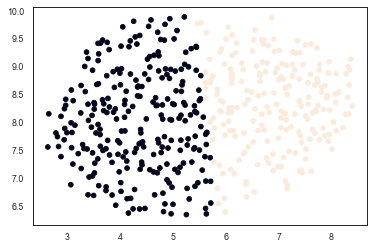

In [34]:
plt.scatter(embedding[:,0], embedding[:,1], c=cl)

In [35]:
df['CLUSTER'] = cl 

In [36]:
df

,LOCATION,ACTIVITIES,PRICE,URL IMAGE,CLUSTER
0,Quito,Cotopaxi National Park & Quilotoa Full-Day Tour,59.48€,https://cdn.getyourguide.com/img/tour/5e3830ed...,0
1,Quito,Historic City of Quito and The Middle of the W...,36.6€,https://cdn.getyourguide.com/img/tour/5c9bb0f3...,1
2,Quito,Otavalo Indian Market Private Day Tour,99.74€,https://cdn.getyourguide.com/img/tour/642b1f4f...,0
3,Quito,From Quito: Guided Day Trip to the Mindo Cloud...,107.98€,https://cdn.getyourguide.com/img/tour/6296b2e5...,1
4,Quito,"From Quito: Otavalo, Cotacachi & Cuicocha Full...",50.33€,https://cdn.getyourguide.com/img/tour/5cf193c4...,0
...,...,...,...,...,...
458,La Paz,From La Paz: Lake Titicaca Tour and Zip Line E...,310.21€,https://cdn.getyourguide.com/img/tour/641e3c03...,1
459,"Copacabana, Bolivia",From La Paz: Lake Titicaca & Islands Private G...,273.61€,https://cdn.getyourguide.com/img/tour/62a75d96...,1
460,La Paz,La Paz: Lake Titicaca and Sun Island Group Tour,105.23€,https://cdn.getyourguide.com/img/tour/63bf7249...,1
461,La Paz,From La Paz: Lake Titicaca and Copacabana Priv...,227.85€,https://cdn.getyourguide.com/img/tour/59df8292...,1


### PRUEBA CON OTRAS IMÁGENES 

Con el mismo proceso de creación del DataFrame inicial, creo un DataFrame de pruebas con las funciones definidas previamente. 

In [37]:
test_urls = [('361'),
        ('114702'),
        ('1')]

headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/111.0',
    'accept-currency': 'EUR',
    'geo-ip-country': 'ES'
}

In [38]:
results_test = url_results(test_urls, headers)

In [39]:
ACTIVITIES_TEST, PRICE_TEST, IMAGE_TEST, LOCATION_TEST = get_data(results_test)

In [40]:
df_test = pd.DataFrame({'LOCATION_TEST': LOCATION_TEST, 'URL IMAGE TEST': IMAGE_TEST})
df_test

,LOCATION_TEST,URL IMAGE TEST
0,Bogotá,https://cdn.getyourguide.com/img/tour/5de6bd6c...
1,Bogotá,https://cdn.getyourguide.com/img/tour/5c1bde44...
2,Bogotá,https://cdn.getyourguide.com/img/tour/6431d69b...
3,Bogotá,https://cdn.getyourguide.com/img/tour/5dcb71a5...
4,Bogotá,https://cdn.getyourguide.com/img/tour/5e7e62ba...
...,...,...
205,Buenos Aires,https://cdn.getyourguide.com/img/tour/5977839d...
206,Buenos Aires,https://cdn.getyourguide.com/img/tour/61b0ce84...
207,Buenos Aires Province,https://cdn.getyourguide.com/img/tour/637fa2d5...
208,Buenos Aires,https://cdn.getyourguide.com/img/tour/642da87c...


In [41]:
df_test.drop_duplicates(inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [106]:
image_emb_pipeline = make_pipeline
Code
(
  ColumnGrabber('URL IMAGE TEST'),
  ImageRetrieval(),
  ImageLoader(convert='RGB'),
  TimmEncoder('mobilenetv2_120d')
)


In [107]:
# Aplico el pipeline definido en el modelo entrenado y lo aplico al DataFrame de pruebas, con esto almaceno
# los nuevos vectores 

embeddings_test = image_emb_pipeline.fit_transform(df_test)


In [398]:
foto_embedding = embeddings_test[67] # puedo indicar números en un rango del 0 al 209

In [401]:
# procedo a calculas las distancias de los vectores de los datos de prueba vs los datos del modelo entrenado
distances = pairwise_distances(embeddings_test, embeddings, metric='cosine')

In [402]:

foto_embedding_reshaped = np.reshape(foto_embedding, (1, -1)) 
# np.reshape(foto_embedding, (1, -1)): es para mantener en una dimensión y calcular 
# automáticamente la otra de acuerdo al tamaño del vector
similarities = cosine_similarity(foto_embedding_reshaped, embeddings)


In [403]:
n_recomendadas = 15 # número de imágenes recomendadas que deseas obtener
recomendadas_idx = pd.DataFrame(similarities.ravel(), columns=['similarity']).nlargest(n_recomendadas, 'similarity').index



In [404]:
recomendadas = df.iloc[recomendadas_idx]

In [406]:
recomendadas

,LOCATION,ACTIVITIES,PRICE,URL IMAGE,CLUSTER
166,Lima,Lima: Ocean Swimming Adventure with Playful Se...,50.24€,https://cdn.getyourguide.com/img/tour/63b89d92...,1
233,Cusco,Chocolate Workshop: from Bean to Bar,26.54€,https://cdn.getyourguide.com/img/tour/4f6109f5...,1
3,Quito,From Quito: Guided Day Trip to the Mindo Cloud...,107.98€,https://cdn.getyourguide.com/img/tour/6296b2e5...,1
226,Cusco,Cusco: Humantay Lake with Breakfast and Buffet...,31.11€,https://cdn.getyourguide.com/img/tour/4ef85392...,1
255,Machu Picchu,Machu Picchu: Private Guided Tour of the Lost ...,41.18€,https://cdn.getyourguide.com/img/tour/5d98a82d...,1
290,Cusco,Cusco: Peruvian Cooking Class & Market Tour,56.73€,https://cdn.getyourguide.com/img/tour/637f8bbb...,1
181,Lima,From Lima: Ballestas Island & Huacachina Oasis...,227.85€,https://cdn.getyourguide.com/img/tour/5cf82371...,1
29,Otavalo,Otavalo: Full day trip from Quito,81.44€,https://cdn.getyourguide.com/img/tour/5ac80955...,1
352,Puno,From Puno: Uros Islands and Taquile Island Ful...,33.86€,https://cdn.getyourguide.com/img/tour/5ccfff81...,1
104,Baños de Agua Santa,Baños de Agua Santa: Whitewater Rafting Tour,27.45€,https://cdn.getyourguide.com/img/tour/5d8bf94d...,1


###  IMAGEN DE EJEMPLO

In [405]:
ipyplot.plot_images([df_test[df_test.index == np.where(embeddings_test==foto_embedding)[0][0]]['URL IMAGE TEST'].iloc[0]], img_width=500)

###  IMAGENES RECOMENDADAS

In [407]:
images = recomendadas['URL IMAGE'].values
labels = recomendadas['LOCATION'].values

ipyplot.plot_images(images, labels, img_width=180)